In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

import sys; sys.path.append('../../')

from data.dataloader import Covid19IndiaLoader
from data.processing.processing import get_data, get_district_time_series, get_dataframes_cached

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from utils.loss import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, train_val_split
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, get_forecast
from viz.forecast import plot_forecast

## Comparison of E/Hosp and I/Hosp ratios

In [9]:
# for district in predictions_dict.keys():
#     district_dict = predictions_dict[district]
    
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-', color='C0', label='E / Hosp (M1)')
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-.', color='C0', label='I / Hosp (M1)')
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#     ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.ylabel('No of People')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
#     plt.grid()
#     plt.show()

## Load Covid19india Data

In [10]:
# dataframes = loader.get_covid19india_api_data()
dataframes = get_dataframes_cached()

../../cache/dataframes_ts_10062020.pkl
pulling from source


In [11]:
predictions_dict = {}

## Select Districts to fit on

In [12]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

#districts_to_show = [('Maharashtra', 'Pune')]
districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

In [13]:
# for state, district in districts_to_show:
#    predictions_dict[(state, district)] = {}
#    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=7, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
#    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=0, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

Performing m1 fit ..
fetching from athenadb...
6191
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
45 2020-05-28  maharashtra   mumbai         35365.8       18766.2    15460.2   
46 2020-05-29  maharashtra   mumbai         36700.4       19567.4    15950.8   
47 2020-05-30  maharashtra   mumbai         38108.8       20494.4    16387.8   
48 2020-05-31  maharashtra   mumbai         39451.4       21505.0    16673.2   
49 2020-06-01  maharashtra   mumbai         40761.8       22473.8    16966.0   

    deceased  
45    1139.4  
46    1182.2  
47    1226.6  
48    1273.2  
49    1322.0  
val
         date        state district  total_infected  hospitalised  recovered  \
0 2020-06-02  maharashtra   mumbai         42058.6       23376.2    17312.8   
1 2020-06-03  maharashtra   mumbai         43336.6       24205.8    17713.4   
2 2020-06-04  maharashtra   mumbai         44586.8       24806.6    18311.6   
3 2020-06-05 

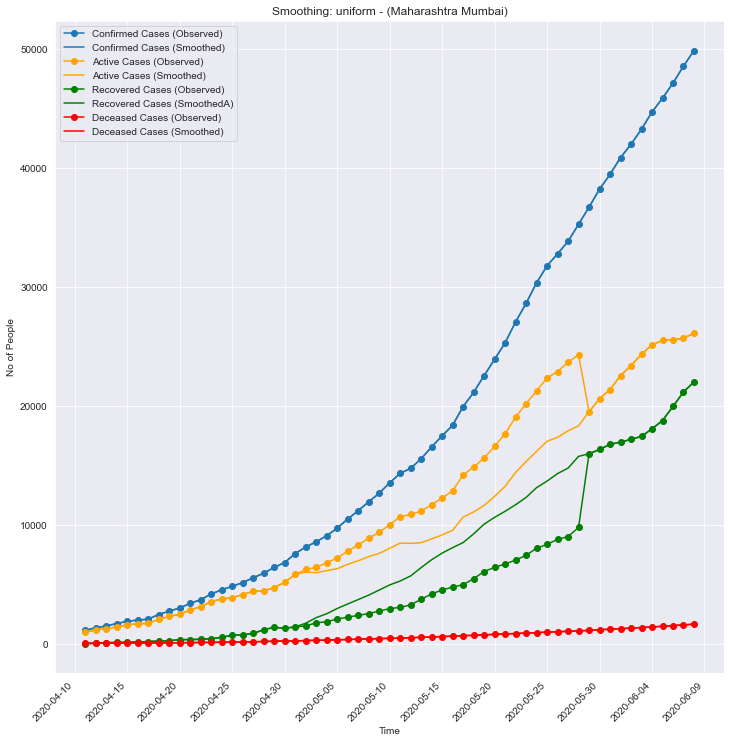

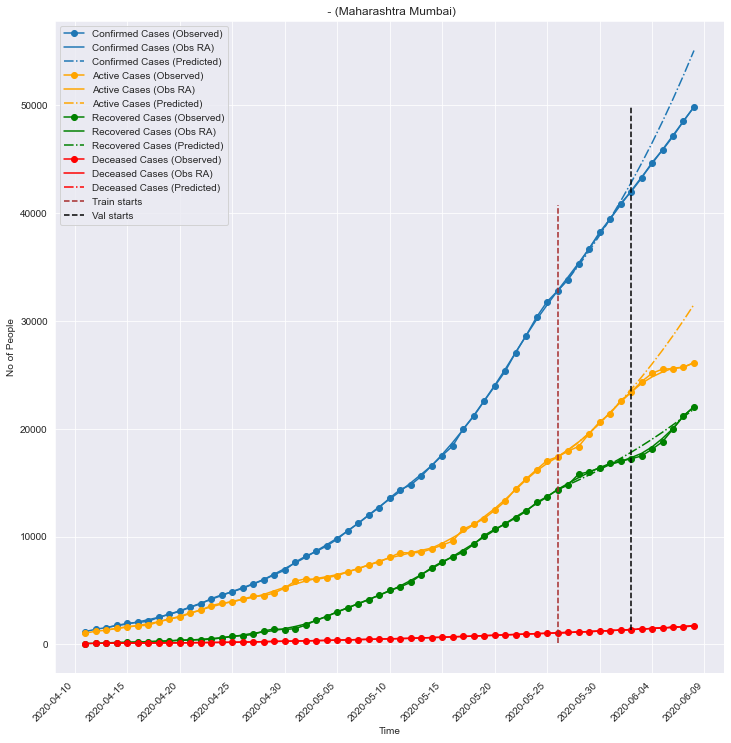

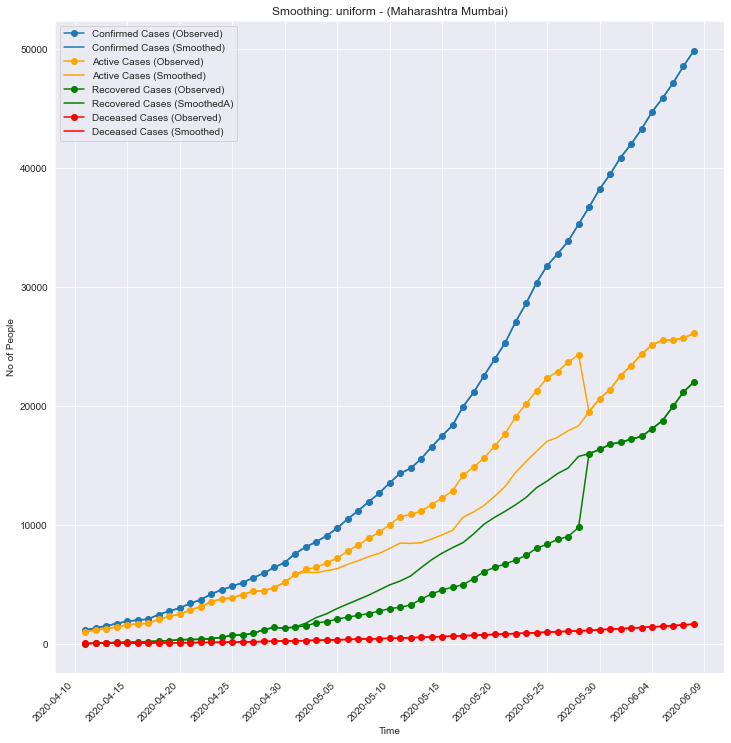

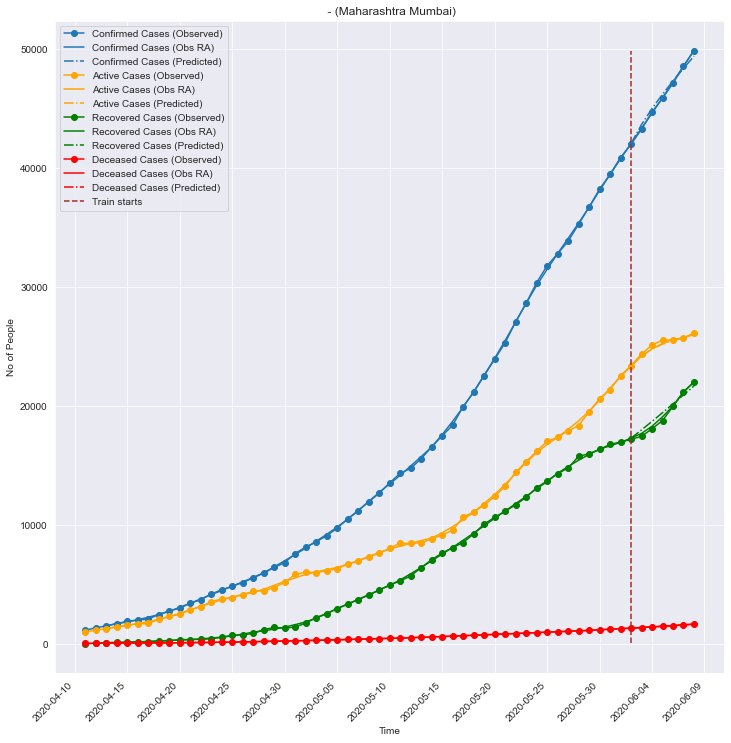

In [14]:
sns.set_style("dark")
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, 
        data_from_tracker=False,
        # filename='../../data/data/official-pune-21-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'],
        smooth_jump = True,
    )
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, 
        data_from_tracker=False, 
        # filename='../../data/data/official-pune-25-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'],
        smooth_jump = True
    )

## Create Master Loss Dataframe

### M1 Loss

In [15]:
predictions_dict.keys()

dict_keys([('Maharashtra', 'Mumbai')])

In [16]:
predictions_dict[('Maharashtra','Mumbai')]['m1'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date', 'smoothing_plot', 'df_district_unsmoothed', 'run_params'])

In [17]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in districts_to_show:
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         0.58           0.37     0.38      1.25   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai         7.81           5.53      0.9      3.03

### M2 Loss

In [18]:
#predictions_dict[('Maharashtra','Pune')]['m2']
predictions_dict[('Maharashtra','Mumbai')]['m2'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date', 'smoothing_plot', 'df_district_unsmoothed', 'run_params'])

In [19]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         0.63           0.59     0.42      2.02

## Plot Forecasts

getting forecasts ..


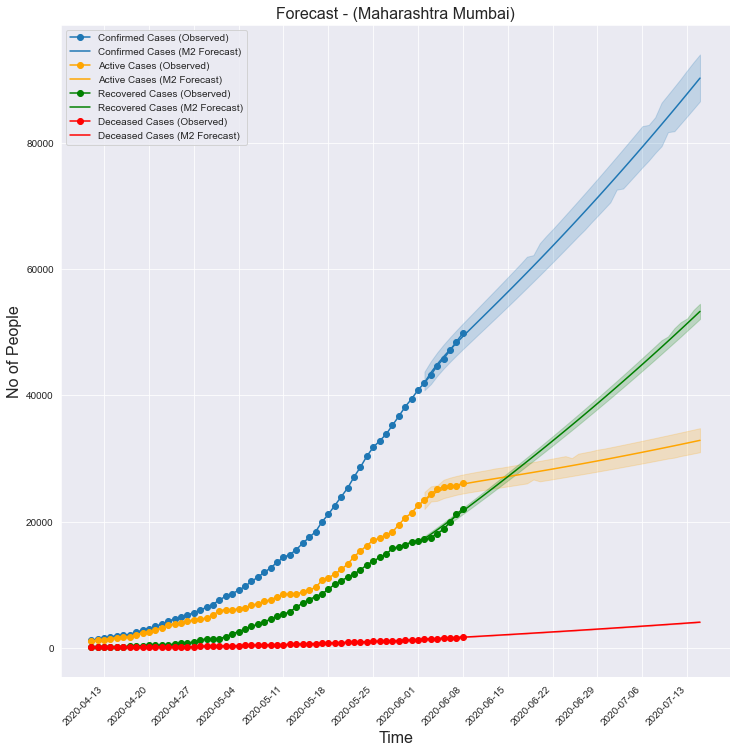

In [20]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create and Save Output CSV

In [21]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [22]:
write_csv(df_output, '../../output-mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [23]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m1']['trials']])
#losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
least_losses_indices = np.argsort(losses_array)
losses_array[least_losses_indices][:10]

array([1.63423481, 1.74713368, 2.02210756, 2.12378637, 2.19120857,
       2.28496851, 2.3639221 , 2.38701434, 2.43497448, 2.50429571])

In [24]:
params_array = []
for trial in predictions_dict[(state, district)]['m1']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [25]:
least_losses_indices[:10]

array([1025,  585,  656, 1302, 1340, 1114,  642, 1042, 1299, 1345])

In [26]:
params_array[least_losses_indices[:10]]

array([{'E_hosp_ratio': 0.46727409310771695, 'I_hosp_ratio': 0.22345584776667993, 'P_fatal': 0.07091147242757509, 'T_inc': 4.626691969855113, 'T_inf': 3.874267701879359, 'T_recov_severe': 38.04962370324097, 'lockdown_R0': 1.4610102746801572},
       {'E_hosp_ratio': 0.3333333621042281, 'I_hosp_ratio': 0.2640728756888876, 'P_fatal': 0.06973454697239892, 'T_inc': 4.548644656901429, 'T_inf': 3.719987325989179, 'T_recov_severe': 36.18546644279622, 'lockdown_R0': 1.4729224307441655},
       {'E_hosp_ratio': 0.4832607059831131, 'I_hosp_ratio': 0.21895602545391402, 'P_fatal': 0.0688169259731125, 'T_inc': 4.592647112237934, 'T_inf': 3.8746676449943855, 'T_recov_severe': 38.843598221359194, 'lockdown_R0': 1.4427279804655064},
       {'E_hosp_ratio': 0.265117695173696, 'I_hosp_ratio': 0.29697414835246433, 'P_fatal': 0.07000229709174231, 'T_inc': 4.554436476885059, 'T_inf': 3.947608379400926, 'T_recov_severe': 38.48528348746896, 'lockdown_R0': 1.4393306809367563},
       {'E_hosp_ratio': 0.351038

In [27]:
#predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Pune')],
#                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]
predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


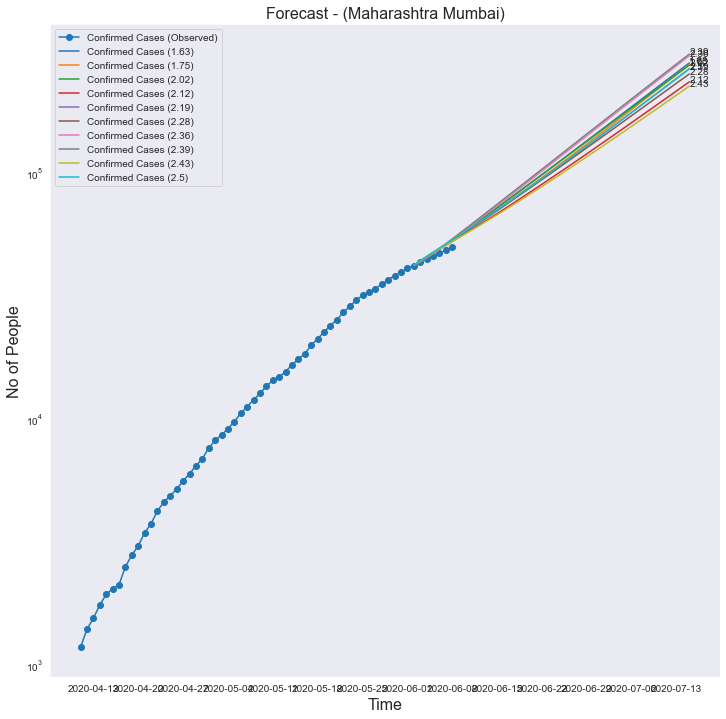

In [28]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']

#sns.set_style("ticks")
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['total_infected'],
        '-o', color='C0', label='Confirmed Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    sns.lineplot(x="date", y="total_infected", data=df_prediction,
                 ls='-', label='Confirmed Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

In [29]:
df_true

,date,state,district,total_infected,hospitalised,recovered,deceased
0,2020-04-11,maharashtra,mumbai,1182,1036,71,75
1,2020-04-12,maharashtra,mumbai,1399,1211,97,91
2,2020-04-13,maharashtra,mumbai,1549,1308,141,100
3,2020-04-14,maharashtra,mumbai,1753,1478,164,111
4,2020-04-15,maharashtra,mumbai,1936,1642,181,113
5,2020-04-16,maharashtra,mumbai,2043,1725,202,116
6,2020-04-17,maharashtra,mumbai,2120,1760,239,121
7,2020-04-18,maharashtra,mumbai,2509,2103,281,125
8,2020-04-19,maharashtra,mumbai,2798,2357,310,131
9,2020-04-20,maharashtra,mumbai,3050,2518,394,138


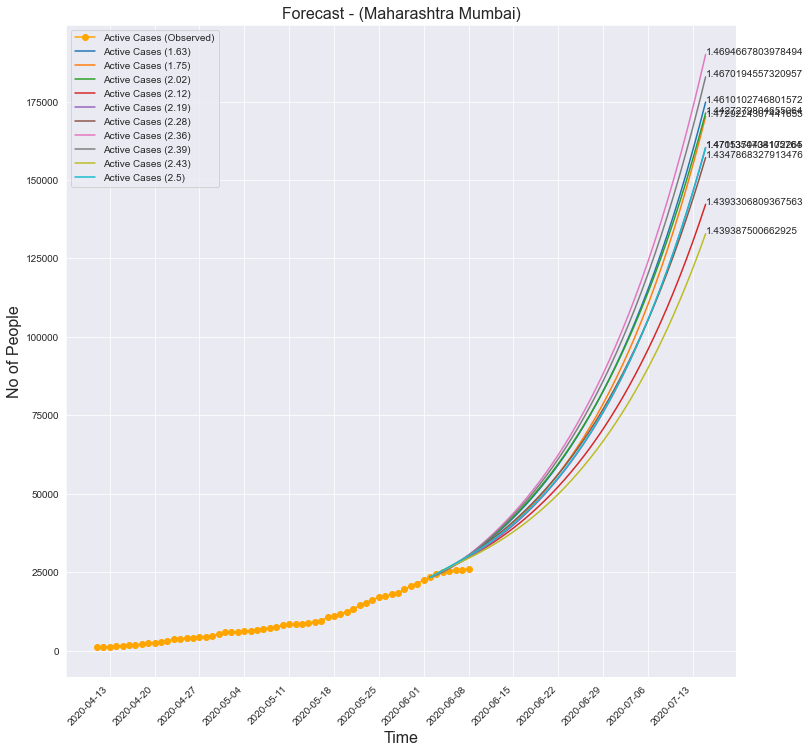

In [30]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = params_dict[i]['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
    #if true_r0 > 1.7:
    #    continue
    #if true_r0 == 0.59 or true_r0 == 1.04:
    #    continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

## Check varying R0 values

In [31]:
params_to_plot = \
{
    'low':{'E_hosp_ratio': 0.115406221316017, 'I_hosp_ratio': 0.4763871081949848, 'P_fatal': 0.050419345187462467, 'P_severe': 0.7809853621826006, 'T_inc': 4.484977212179257, 'T_inf': 3.3342249004558697, 'T_recov_severe': 52.054485355979445, 'lockdown_R0': 1.0974118812671074},
    'medium':{'E_hosp_ratio': 0.5105188613649609, 'I_hosp_ratio': 0.3039459885534656, 'P_fatal': 0.05832975188719784, 'P_severe': 0.8668707539589996, 'T_inc': 4.554494614633725, 'T_inf': 3.3958101193846915, 'T_recov_severe': 48.49542471232895, 'lockdown_R0': 1.1227557408135034},
    'high':   {'E_hosp_ratio': 0.2806960144261442, 'I_hosp_ratio': 0.3800638057872212, 'P_fatal': 0.05326820833691313, 'P_severe': 0.8339542948758695, 'T_inc': 4.304052648857938, 'T_inf': 3.4673218430188513, 'T_recov_severe': 47.044942872805294, 'lockdown_R0': 1.3444274930627533}
}
multipliers = [0.9, 1, 1.1, 1.25]
columns_for_csv = ['date', 'total_infected', 'hospitalised', 'recovered', 'deceased']


In [32]:
def set_r0_multiplier(params_dict, mul):
    new_params = params_dict.copy()
    new_params['post_lockdown_R0']= params_dict['lockdown_R0']*mul
    return new_params


#predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
#                                  best_params=set_r0_multiplier(best_params_dict, mul)) \
#                                 for mul in multipliers]

In [35]:
lc = Loss_Calculator()

In [36]:

df_district = predictions_dict[districts_to_show[0]]['m2']['df_district']
df_train_nora, df_val_nora, df_true_fitting = train_val_split(
                df_district, train_rollingmean=False, val_rollingmean=False, val_size=0)

for key in params_to_plot:
    print("R0", params_to_plot[key]['lockdown_R0'])
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params = best_params_dict)
    df_loss = lc.create_loss_dataframe_region(df_train_nora, df_val_nora, df_predictions, train_period=7,
                             which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss)
    #print(df_loss.sum())

splitting data ..
R0 1.0974118812671074
getting forecasts ..
                  train
hospitalised    12.8258
total_infected  6.83372
deceased        1.80453
recovered        2.9114
R0 1.1227557408135034
getting forecasts ..
                   train
hospitalised     11.0484
total_infected   5.87316
deceased        0.739262
recovered        2.74491
R0 1.3444274930627533
getting forecasts ..
                  train
hospitalised    11.2991
total_infected  6.10684
deceased        1.48695
recovered       2.59832


getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-low-0.9.csv
Mumbai-low-1.csv
Mumbai-low-1.1.csv
Mumbai-low-1.25.csv


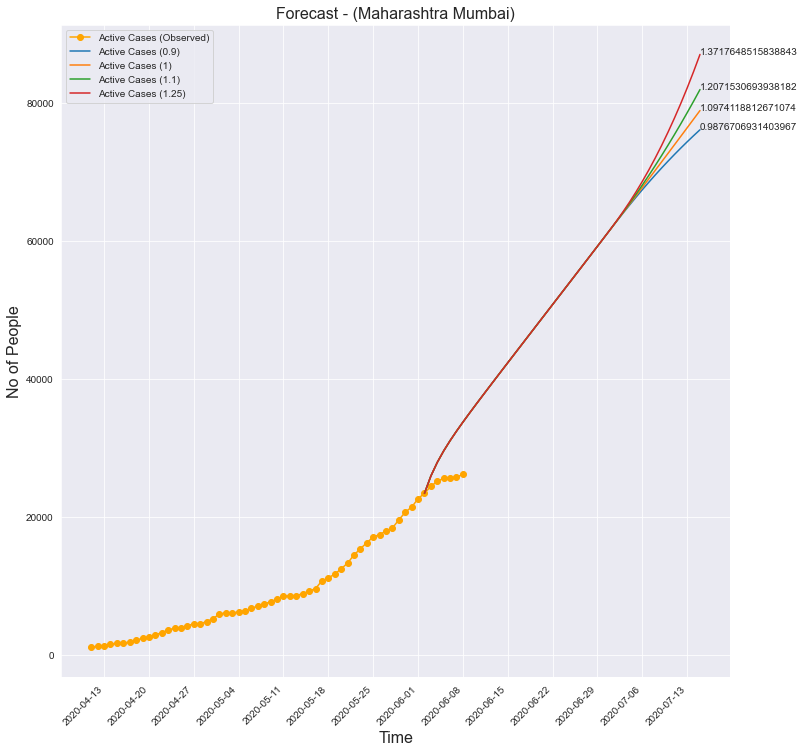

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-medium-0.9.csv
Mumbai-medium-1.csv
Mumbai-medium-1.1.csv
Mumbai-medium-1.25.csv


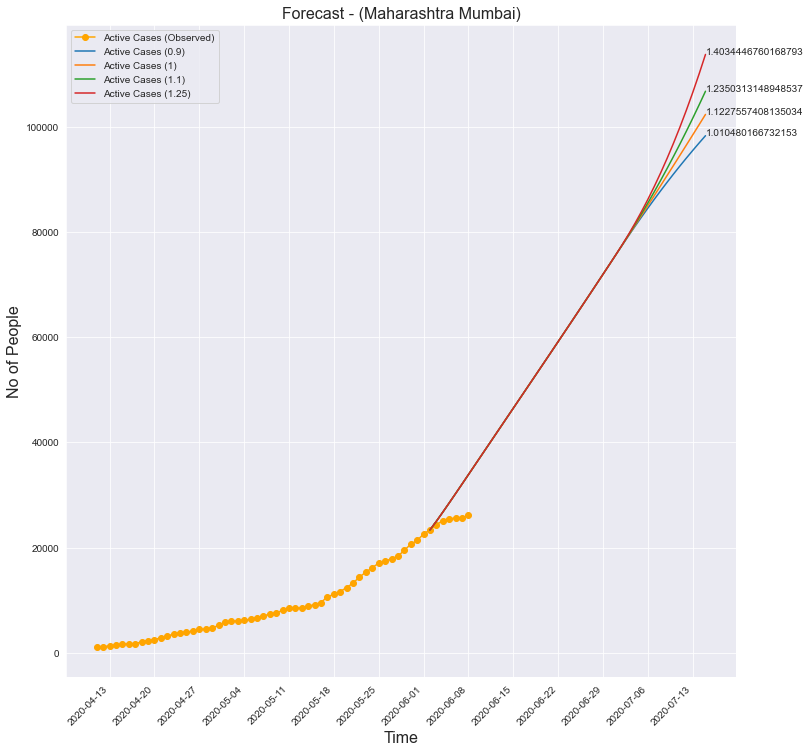

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Mumbai-high-0.9.csv
Mumbai-high-1.csv
Mumbai-high-1.1.csv
Mumbai-high-1.25.csv


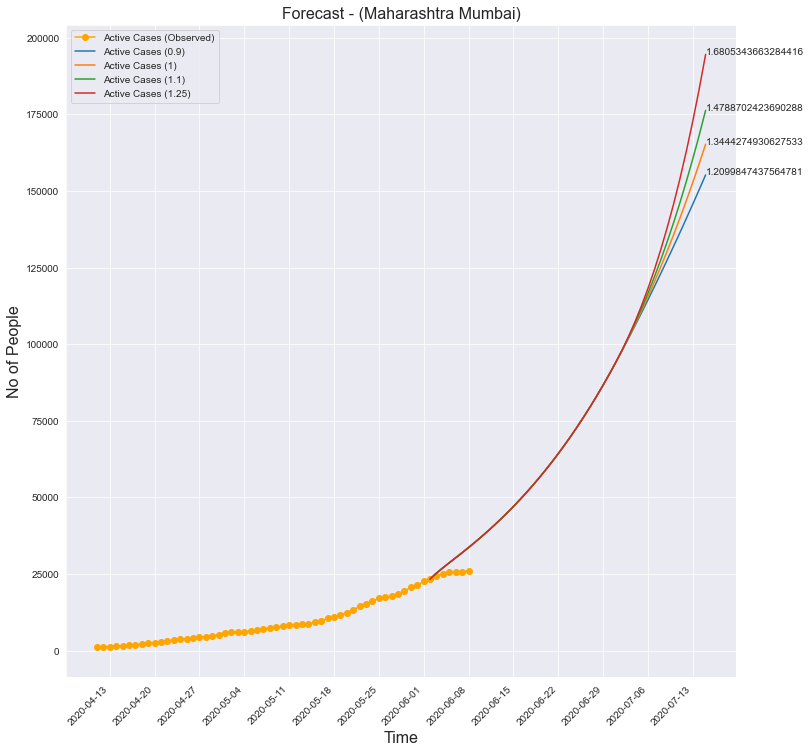

In [37]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
params_array[least_losses_indices[:10]]
for key in params_to_plot:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params=set_r0_multiplier(best_params_dict, mul))
                                 for mul in multipliers]
    for i, df_prediction in enumerate(predictions_array_mul):
        filename = "Mumbai-" + key + "-" + str(multipliers[i]) + ".csv"
        print(filename)
        today = datetime.date.today().strftime("%Y-%m-%d")
        path = f'../../outputs/Mumbai-{today}/'
        if not os.path.exists(path):
            os.mkdir(path)
        df_prediction[columns_for_csv].to_csv(os.path.join(path, filename))
        #loss_value = np.around(np.sort(losses_array)[:10][i], 2)
        label = multipliers[i]
        true_r0 = label*best_params_dict['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
        #if true_r0 > 1.7:
        #    continue
        #if true_r0 == 0.59 or true_r0 == 1.04:
        #    continue
        sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                     ls='-', label='Active Cases ({})'.format(label))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    # plt.yscale('log')
    plt.xticks(rotation=45,horizontalalignment='right')

    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    plt.show()     

In [38]:

for elt in params_array[least_losses_indices[:10]]:
    print("R0", elt['lockdown_R0'])
    #best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(
        predictions_dict[('Maharashtra', 'Mumbai')],
        train_fit = "m1",
        best_params = elt)
    df_loss =  lc.create_loss_dataframe_region(
        df_train_nora, df_val_nora, df_predictions, train_period=7,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss.iloc[1])


R0 1.4610102746801572
getting forecasts ..
train    5.53377
Name: total_infected, dtype: object
R0 1.4729224307441655
getting forecasts ..
train    4.41486
Name: total_infected, dtype: object
R0 1.4427279804655064
getting forecasts ..
train    5.75274
Name: total_infected, dtype: object
R0 1.4393306809367563
getting forecasts ..
train    2.23918
Name: total_infected, dtype: object
R0 1.4711354708105764
getting forecasts ..
train    3.95832
Name: total_infected, dtype: object
R0 1.4347868327913476
getting forecasts ..
train    4.17436
Name: total_infected, dtype: object
R0 1.4694667803978494
getting forecasts ..
train    6.68565
Name: total_infected, dtype: object
R0 1.4670194557320957
getting forecasts ..
train    7.79615
Name: total_infected, dtype: object
R0 1.439387500662925
getting forecasts ..
train    1.6602
Name: total_infected, dtype: object
R0 1.4705370434172265
getting forecasts ..
train    4.69564
Name: total_infected, dtype: object


In [39]:
columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered',
           'current_deceased', 'current_hospitalized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min',
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean',
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

region = ('Maharashtra', 'Mumbai')

df_final = pd.DataFrame(columns=columns)
for params_dict in params_array[least_losses_indices[:10]]:
    df_output = create_region_csv(predictions_dict[region], region=region[1],
    regionType='district', best_params=params_dict,
    icu_fraction=0.02)
    df_final = pd.concat([df_final, df_output], ignore_index=True)
    

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [40]:
df_final.to_csv('../../outputs/mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [41]:
df_final

,forecastRunDate,regionType,region,model_name,error_function,error_value,current_total,current_active,current_recovered,current_deceased,...,icu_max,deceased_mean,deceased_min,deceased_max,recovered_mean,recovered_min,recovered_max,total_mean,total_min,total_max
0,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,1182,NaN,71,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,1399,NaN,97,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,1549,NaN,141,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,1753,NaN,164,111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,1936,NaN,181,113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,NaN,NaN,NaN,NaN,...,2871.5,6463,6405,6521,80850,78403.8,83296.2,220484,208284,232684
956,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,NaN,NaN,NaN,NaN,...,3008.23,6748,6687.44,6808.56,84438,81883.2,86992.8,230698,217932,243464
957,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,NaN,NaN,NaN,NaN,...,3151.27,7048,6984.75,7111.25,88197,85528.5,90865.5,241391,228034,254748
958,2020-06-10,district,Mumbai,SEIR,MAPE,5.533476,NaN,NaN,NaN,NaN,...,3300.87,7361,7294.94,7427.06,92134,89346.4,94921.6,252579,238603,266555


In [42]:
for index, params_dict in enumerate(params_array[least_losses_indices[:10]]):
    print('Loss - ', np.around(losses_array[least_losses_indices[:10][index]], 2))
    params_dict_temp = copy.copy(params_dict)
    params_dict_temp['true_R0'] = params_dict_temp['lockdown_R0']#*params_dict_temp['intervention_amount']
    #del params_dict_temp['intervention_amount']
    del params_dict_temp['lockdown_R0']
    for key in params_dict_temp.keys():
        params_dict_temp[key] = np.around(params_dict_temp[key], 2)
    print('Params - ', params_dict_temp)
    print('\n')

Loss -  1.63
Params -  {'E_hosp_ratio': 0.47, 'I_hosp_ratio': 0.22, 'P_fatal': 0.07, 'T_inc': 4.63, 'T_inf': 3.87, 'T_recov_severe': 38.05, 'true_R0': 1.46}


Loss -  1.75
Params -  {'E_hosp_ratio': 0.33, 'I_hosp_ratio': 0.26, 'P_fatal': 0.07, 'T_inc': 4.55, 'T_inf': 3.72, 'T_recov_severe': 36.19, 'true_R0': 1.47}


Loss -  2.02
Params -  {'E_hosp_ratio': 0.48, 'I_hosp_ratio': 0.22, 'P_fatal': 0.07, 'T_inc': 4.59, 'T_inf': 3.87, 'T_recov_severe': 38.84, 'true_R0': 1.44}


Loss -  2.12
Params -  {'E_hosp_ratio': 0.27, 'I_hosp_ratio': 0.3, 'P_fatal': 0.07, 'T_inc': 4.55, 'T_inf': 3.95, 'T_recov_severe': 38.49, 'true_R0': 1.44}


Loss -  2.19
Params -  {'E_hosp_ratio': 0.35, 'I_hosp_ratio': 0.27, 'P_fatal': 0.07, 'T_inc': 4.63, 'T_inf': 3.89, 'T_recov_severe': 35.13, 'true_R0': 1.47}


Loss -  2.28
Params -  {'E_hosp_ratio': 0.34, 'I_hosp_ratio': 0.27, 'P_fatal': 0.07, 'T_inc': 4.53, 'T_inf': 3.86, 'T_recov_severe': 40.13, 'true_R0': 1.43}


Loss -  2.36
Params -  {'E_hosp_ratio': 0.56, '

# Find beta and mean params for uncertainty estimation

#TODO
1. Check with Excel file (potentially different value of N) -> they use N = 1000. chekc that data is same too.
2. Check between 0 and 0.2
3. N = 2000
4. Mean forecast matching
5. Compare your code with excel (their best beta was 0.9)
6. 

-------



In [43]:
compartment_list = ['hospitalised', 'total_infected', 'deceased', 'recovered']

In [44]:
params_array_m1 = []
for trial in predictions_dict[(state, district)]['m1']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array_m1.append(params_dict)

params_array_m1= np.array(params_array_m1)

In [45]:
losses_array_m1 = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m1']['trials']])
least_losses_indices_m1 = np.argsort(losses_array_m1)

In [46]:
num_samples=range(10,2000,10)
betas= np.arange(0, 1,0.025)

params_fulldict_m1 = params_array_m1[least_losses_indices_m1]
params_list = list(params_array_m1[0].keys())
means_m1 = {}
std_devs_m1 = {}
sums_m1 = {}
sqsums_m1 = {}

for i, beta in enumerate(betas):
    means_m1[i] = {}
    std_devs_m1[i] = {}
    for key in params_list:
        means_m1[i][key] = []
        std_devs_m1[i][key] = []
    for nums in num_samples:
        Loss_norm_m1=0
        for key in params_list:
            sums_m1[key] = 0
            sqsums_m1[key] = 0
        tempdict_m1 = params_fulldict_m1[0:nums]
        templosses_m1 = losses_array_m1[least_losses_indices_m1[0:nums]]
        for k in range(len(tempdict_m1)):
            Loss_norm_m1 += np.exp(-beta*templosses_m1[k])
            for key in params_list:
                sums_m1[key] += np.exp(-beta*templosses_m1[k])*tempdict_m1[k][key]
                sqsums_m1[key] += np.exp(-beta*templosses_m1[k])*tempdict_m1[k][key]**2
        for key in params_list:
            means_m1[i][key].append(sums_m1[key]/Loss_norm_m1)
            std_devs_m1[i][key].append(np.sqrt(sqsums_m1[key]/Loss_norm_m1-(sums_m1[key]/Loss_norm_m1)**2))
                

In [47]:
means_m1[0]['E_hosp_ratio'][-5:]

[0.48451427192487667,
 0.48451427192487667,
 0.48451427192487667,
 0.48451427192487667,
 0.48451427192487667]

In [48]:
params_list

['E_hosp_ratio',
 'I_hosp_ratio',
 'P_fatal',
 'T_inc',
 'T_inf',
 'T_recov_severe',
 'lockdown_R0']

In [ ]:
fig, axs = plt.subplots(len(params_list),2)
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.figsize']=[30, 50]
plt.rcParams.update({'font.size':20})
colors =['blue','brown', 'black','green','orange','red']
for row, key in enumerate(params_list):
    for idx, betaind in enumerate([0,1,2,5,10,30]):    
        axs[row,0].plot(num_samples, means_m1[betaind][key] , color = colors[idx],label=r'\beta=${:.1f}'.format(betas[betaind]))
        axs[row,0].set_title('{}'.format(key))
        axs[row,0].set(ylabel= "Estimated Mean")
        axs[row,1].plot(num_samples,std_devs_m1[betaind][key], color = colors[idx],label=r'$\beta=${:.1f}'.format(betas[betaind]))
        axs[row,1].set_title('{}'.format(key))
        axs[row,1].set(ylabel="Estimated Std. Devn.")
        if (row==0):
            axs[row,0].legend(loc='center right')
        if (row==3):
            axs[row,0].set(xlabel="Number of top Hyperopt samples")
            axs[row,1].set(xlabel="Number of top Hyperopt samples")

fig.tight_layout(pad = 1.0)

In [50]:
# Define N from plots!
N = 1500

In [51]:
len(means_m1[i][key])

199

In [107]:
# On val set, instead of taking mean param, take mean forecast. For each param set, compute forecast on the val set
#and then weight each trjectory by e^(-loss), use to pick beta
# Function(betas, params-len 1500), computes mean forecast on given time range. 
# Get_losses function for this mean forecast

def get_loss_mean_param(i):
    skip_length = 10
    mean_params = {key:means_m1[i][key][N // skip_length] for key in params_list} 
    df_train = predictions_dict[districts_to_show[0]]['m1']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m1']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m1',
                                best_params=mean_params)
    df_loss =  lc.create_loss_dataframe_region(df_train, df_val, df_predictions, train_period=7,
                                 which_compartments= compartment_list )
    return df_loss





def get_mean_forecast(i, train_fit = 'm1'):
    beta = betas[i]
    if train_fit == 'm1':
        tempdict= params_fulldict_m1[0:N]
        templosses = losses_array_m1[least_losses_indices_m1[0:N]]
    else:
        tempdict= params_fulldict_m2[0:N]
        templosses = losses_array_m2[least_losses_indices_m2[0:N]]
    Loss_norm = 0
    df_predictions = pd.DataFrame()
    for k in range(len(tempdict)):
        weight_trial = np.exp(-beta*templosses[k])
        param_trial = tempdict[k]
        df_predictions_trial= get_forecast(predictions_dict[districts_to_show[0]],
                                    train_fit= train_fit,
                                    best_params=param_trial)#* weight_trial
        Loss_norm += weight_trial
        if (df_predictions.empty):
            df_predictions = df_predictions_trial[compartment_list]*weight_trial
        else:
            df_predictions += df_predictions_trial[compartment_list]*weight_trial
    df_predictions = df_predictions/Loss_norm
    df_predictions['date'] = df_predictions_trial.date
    return df_predictions

def get_loss_mean_forecast(i):
    print("FORECAST MEAN FOR ",i)
    print("*"*20)
    df_train = predictions_dict[districts_to_show[0]]['m1']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m1']['df_val']
    df_predictions =  get_mean_forecast(i)
    df_loss =  lc.create_loss_dataframe_region(df_train, df_val, df_predictions, train_period=7,
                                 which_compartments= compartment_list )
    return df_loss
    
    

In [53]:
losses = [get_loss_mean_param(i) for i in range(len(betas))]
val_losses = [loss['val'].sum() for loss in losses]
min_loss_ind = np.argmin(val_losses)
beta_min = betas[min_loss_ind]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [55]:
np.argmin(val_losses)

18

In [56]:
print(beta_min )

0.45


In [91]:
losses_forecast = [get_loss_mean_forecast(i) for i in range(len(betas))]
val_losses_forecast = [loss['val'].sum() for loss in losses_forecast]
min_loss_ind_forecast = np.argmin(val_losses_forecast)

In [99]:
val_losses_forecast 

[32.784567004863206,
 23.23449556652676,
 18.758802138039467,
 16.40194996148585,
 15.044688146838043,
 14.214137699660743,
 13.741811162091278,
 13.427254294668838,
 13.228166897088954,
 13.105043956538344,
 13.021446869791134,
 12.96258702019515,
 12.922540660303504,
 12.895552515398665,
 12.874737492089949,
 12.85841427087515,
 12.845080742428982,
 12.834569694196023,
 12.826554381909183,
 12.820552414684135,
 12.818008787851975,
 12.818511211044456,
 12.820612033374045,
 12.825438661150717,
 12.8336114017882,
 12.842921691383301,
 12.853213655137974,
 12.864356654709898,
 12.876240649544823,
 12.888772497277118,
 12.90187297829042,
 12.918296403214885,
 12.935419510826595,
 12.952862424878134,
 12.970576017557502,
 12.98851801395221,
 13.006651892278715,
 13.024945969513523,
 13.043372639380463,
 13.061907735977252]

# Generate uncertainty estimates using M2 fits

In [93]:
params_array_m2 = []
for trial in predictions_dict[(state, district)]['m2']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array_m2.append(params_dict)

params_array_m2= np.array(params_array_m2)

In [59]:
params_array_m2

array([{'E_hosp_ratio': 1.5732039238267495, 'I_hosp_ratio': 0.8574668039589824, 'P_fatal': 0.09786943032126416, 'T_inc': 4.499054469339689, 'T_inf': 3.387601457913453, 'T_recov_severe': 54.37731970676451, 'lockdown_R0': 1.026299165833684},
       {'E_hosp_ratio': 0.10771603896595616, 'I_hosp_ratio': 0.951064229938323, 'P_fatal': 0.2630654639371173, 'T_inc': 4.867904974453634, 'T_inf': 3.448021496493361, 'T_recov_severe': 13.126507023253353, 'lockdown_R0': 1.105864219529723},
       {'E_hosp_ratio': 0.880493083081402, 'I_hosp_ratio': 0.37207906000875157, 'P_fatal': 0.07779647413818475, 'T_inc': 4.298150917266516, 'T_inf': 3.361813389304973, 'T_recov_severe': 6.100515470851484, 'lockdown_R0': 1.4186385582486032},
       ...,
       {'E_hosp_ratio': 0.3406981224709386, 'I_hosp_ratio': 0.10727342726905992, 'P_fatal': 0.06253269409872635, 'T_inc': 4.831146592972444, 'T_inf': 3.750257956205654, 'T_recov_severe': 28.62323075564489, 'lockdown_R0': 1.0242126474920263},
       {'E_hosp_ratio': 0

In [61]:
# Compute weighted estimates for m2 (only for a single point)

losses_array_m2 = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
least_losses_indices_m2 = np.argsort(losses_array_m2)

nums= N
params_fulldict_m2 = params_array_m2[least_losses_indices_m2]
mean_m2 = {}
std_devs_m2 = {}
sums_m2 = {}
sqsums_m2 = {}

for key in params_list:
    sums_m2[key] = 0
    sqsums_m2[key] = 0
Loss_norm_m2 = 0
tempdict_m2 = params_fulldict_m2[0:nums]
templosses_m2 = losses_array_m2[least_losses_indices_m2[0:nums]]
for k in range(len(tempdict_m2)):
    Loss_norm_m2 += np.exp(-beta_min*templosses_m2[k])
    for key in params_list:
        sums_m2[key] += np.exp(-beta_min*templosses_m2[k])*tempdict_m2[k][key]
        sqsums_m2[key] += np.exp(-beta_min*templosses_m2[k])*tempdict_m2[k][key]**2
for key in params_list:
    mean_m2[key] = sums_m2[key]/Loss_norm_m2
    std_devs_m2[key] = np.sqrt(sqsums_m2[key]/Loss_norm_m2-(sums_m2[key]/Loss_norm_m2)**2)



In [62]:
best_params_m2 = params_fulldict_m2[:N]
best_params_total_loss_m2 = sum(np.exp(-beta_min * losses_array[least_losses_indices[:N]]))

In [76]:
def get_preds_m2():    
    df_train = predictions_dict[districts_to_show[0]]['m2']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m2']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m2',
                                best_params=mean_m2)
    return df_predictions

def get_loss_m2(params):
    N = 1500
    skip_length = 10
    df_train = predictions_dict[districts_to_show[0]]['m2']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m2']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m2',
                                best_params=params)
    df_loss =  lc.create_loss_dataframe_region(df_train, df_val, df_predictions, train_period=7,
                                 which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    return df_loss

In [66]:
#m2_losses = [get_loss_m2(params)['train'] for params in best_params_m2]
m2_losses = losses_array_m2[least_losses_indices_m2]

In [67]:
all_forecasts = pd.DataFrame()
for params in best_params_m2:
    all_forecasts = pd.concat([all_forecasts , get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                                train_fit='m2',
                                                best_params=params)], axis = 1)

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

In [68]:
mean_m2

{'E_hosp_ratio': 0.22547495433339063,
 'I_hosp_ratio': 0.22130116913664255,
 'P_fatal': 0.06857856436886318,
 'T_inc': 4.777656321208277,
 'T_inf': 3.7190924544843553,
 'T_recov_severe': 32.92762694863846,
 'lockdown_R0': 1.0924614015705554}

In [69]:
all_forecasts

,date,S,E,I,D_E,D_I,R_mild,R_severe,R_fatal,C,...,R_mild,R_severe,R_fatal,C,D,hospitalised,recovered,deceased,infectious_unknown,total_infected
0,2020-06-02,9949767,1460,6713,0,0,0,21733,1642,17312,...,0,16378,6997,17312,1369,23375,17312,1369,21738,42056
1,2020-06-03,9948076,2722,5554,0,0,0,22515,1701,18008,...,0,20416,8618,17636,1612,29034,17636,1612,25372,48282
2,2020-06-04,9946641,3523,4840,0,0,0,23052,1742,18723,...,0,24920,10416,18036,1910,35336,18036,1910,27731,55282
3,2020-06-05,9945362,4040,4401,0,0,0,23439,1771,19453,...,0,29701,12309,18518,2265,42010,18518,2265,29345,62793
4,2020-06-06,9944181,4373,4140,0,0,0,23730,1794,20194,...,0,34652,14252,19086,2679,48904,19086,2679,30514,70669
5,2020-06-07,9943055,4597,3983,0,0,0,23966,1812,20942,...,0,39700,16213,19742,3155,55913,19742,3155,31438,78810
6,2020-06-08,9941962,4750,3896,0,0,0,24165,1827,21698,...,0,44816,18180,20488,3693,62996,20488,3693,32206,87177
7,2020-06-09,9940888,4858,3853,0,0,0,24342,1840,22459,...,0,49974,20143,21324,4292,70117,21324,4292,32887,95733
8,2020-06-10,9939822,4940,3836,0,0,0,24507,1853,23226,...,0,55161,22095,22252,4952,77256,22252,4952,33526,104460
9,2020-06-11,9938757,5005,3834,0,0,0,24665,1865,23997,...,0,60370,24036,23272,5673,84406,23272,5673,34136,113351


In [70]:
# This function should also pick the interbval (95% etc)
# Also give it functionality to pick a percentile
# also include a median prediction -> if 2 

    
def gen_CI(day = 1, compartment = 'hospitalised', CI = 0.95, beta = beta_min, percentile = -1):
    daily_forecasts = all_forecasts[compartment].iloc[day,:]
    sorted_daily_forecasts_indices = np.argsort(daily_forecasts)
    sorted_daily_forecasts = np.sort(daily_forecasts)
    sorted_losses_array = m2_losses[:N][sorted_daily_forecasts_indices]
    
    best_params_total_loss_m2 = sum(np.exp(-beta * losses_array[least_losses_indices[:N]]))
    
    if (percentile >= 0):
        bound = 0 
        score = 0 
        threshold = percentile * best_params_total_loss_m2
        while score < threshold:
            score += np.exp(- beta*sorted_losses_array[bound])
            bound += 1
        forecast = sorted_daily_forecasts[bound]   
        return all_forecasts['date'].iloc[day,0], forecast, forecast
    else:
        threshold_factor = (1 - CI)/ 2
        threshold = threshold_factor * best_params_total_loss_m2
        upperbound = N-1
        lowerbound = 0 
        upperscore, lowerscore = 0, 0
        while upperscore < threshold:
            upperscore += np.exp(- beta*sorted_losses_array[upperbound])
            upperbound -= 1
        while lowerscore < threshold:
            lowerscore += np.exp(- beta*sorted_losses_array[lowerbound])
            lowerbound += 1
        lower_forecast = sorted_daily_forecasts[lowerbound]
        upper_forecast = sorted_daily_forecasts[upperbound]
        return all_forecasts['date'].iloc[day,0], lower_forecast, upper_forecast

In [72]:
predictions_dict[('Maharashtra','Mumbai')]['m1']['df_district_unsmoothed'][40:50]

,state,district,date,total_infected,hospitalised,recovered,deceased
90,maharashtra,mumbai,2020-05-21,25317,17684,6751,882
91,maharashtra,mumbai,2020-05-22,27068,19079,7080,909
92,maharashtra,mumbai,2020-05-23,28634,20209,7476,949
93,maharashtra,mumbai,2020-05-24,30359,21297,8074,988
94,maharashtra,mumbai,2020-05-25,31789,22359,8404,1026
95,maharashtra,mumbai,2020-05-26,32791,22912,8814,1065
96,maharashtra,mumbai,2020-05-27,33835,23684,9054,1097
97,maharashtra,mumbai,2020-05-28,35273,24321,9817,1135
98,maharashtra,mumbai,2020-05-29,36710,19529,16008,1173
99,maharashtra,mumbai,2020-05-30,38220,20629,16364,1227


In [73]:
predictions_dict[('Maharashtra','Mumbai')]['m1']['df_district'][40:50]

,date,state,district,total_infected,hospitalised,recovered,deceased
40,2020-05-21,maharashtra,mumbai,25317,13262,11173,882
41,2020-05-22,maharashtra,mumbai,27068,14436,11723,909
42,2020-05-23,maharashtra,mumbai,28634,15345,12340,949
43,2020-05-24,maharashtra,mumbai,30359,16212,13159,988
44,2020-05-25,maharashtra,mumbai,31789,17053,13710,1026
45,2020-05-26,maharashtra,mumbai,32791,17385,14341,1065
46,2020-05-27,maharashtra,mumbai,33835,17936,14802,1097
47,2020-05-28,maharashtra,mumbai,35273,18352,15786,1135
48,2020-05-29,maharashtra,mumbai,36710,19529,16008,1173
49,2020-05-30,maharashtra,mumbai,38220,20629,16364,1227


In [108]:
df_predictions_mf = get_mean_forecast(min_loss_ind_forecast, 'm2')

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

In [109]:
pd.concat([df_predictions_mf, df_predictions[['recovered', 'date']]], axis = 1)

,hospitalised,total_infected,deceased,recovered,date,recovered,date
0,23375.214682,42056.214682,1369.000000,17312.000000,2020-06-02,17312,2020-06-02
1,24001.055037,43420.341550,1419.857730,17999.428783,2020-06-03,17983,2020-06-03
2,24559.559488,44734.932575,1471.922308,18703.450779,2020-06-04,18670,2020-06-04
3,25076.961357,46024.803864,1525.068831,19422.773676,2020-06-05,19374,2020-06-05
4,25567.965752,47303.828257,1579.309959,20156.552547,2020-06-06,20092,2020-06-06
5,26043.213925,48581.924192,1634.620524,20904.089743,2020-06-07,20824,2020-06-07
6,26508.387515,49864.335144,1690.866672,21665.080958,2020-06-08,21571,2020-06-08
7,26967.028947,51154.393225,1748.172128,22439.192150,2020-06-09,22331,2020-06-09
8,27421.742625,52454.529584,1806.419106,23226.367853,2020-06-10,23104,2020-06-10
9,27874.102425,53766.148320,1865.620362,24026.425533,2020-06-11,23891,2020-06-11


getting forecasts ..


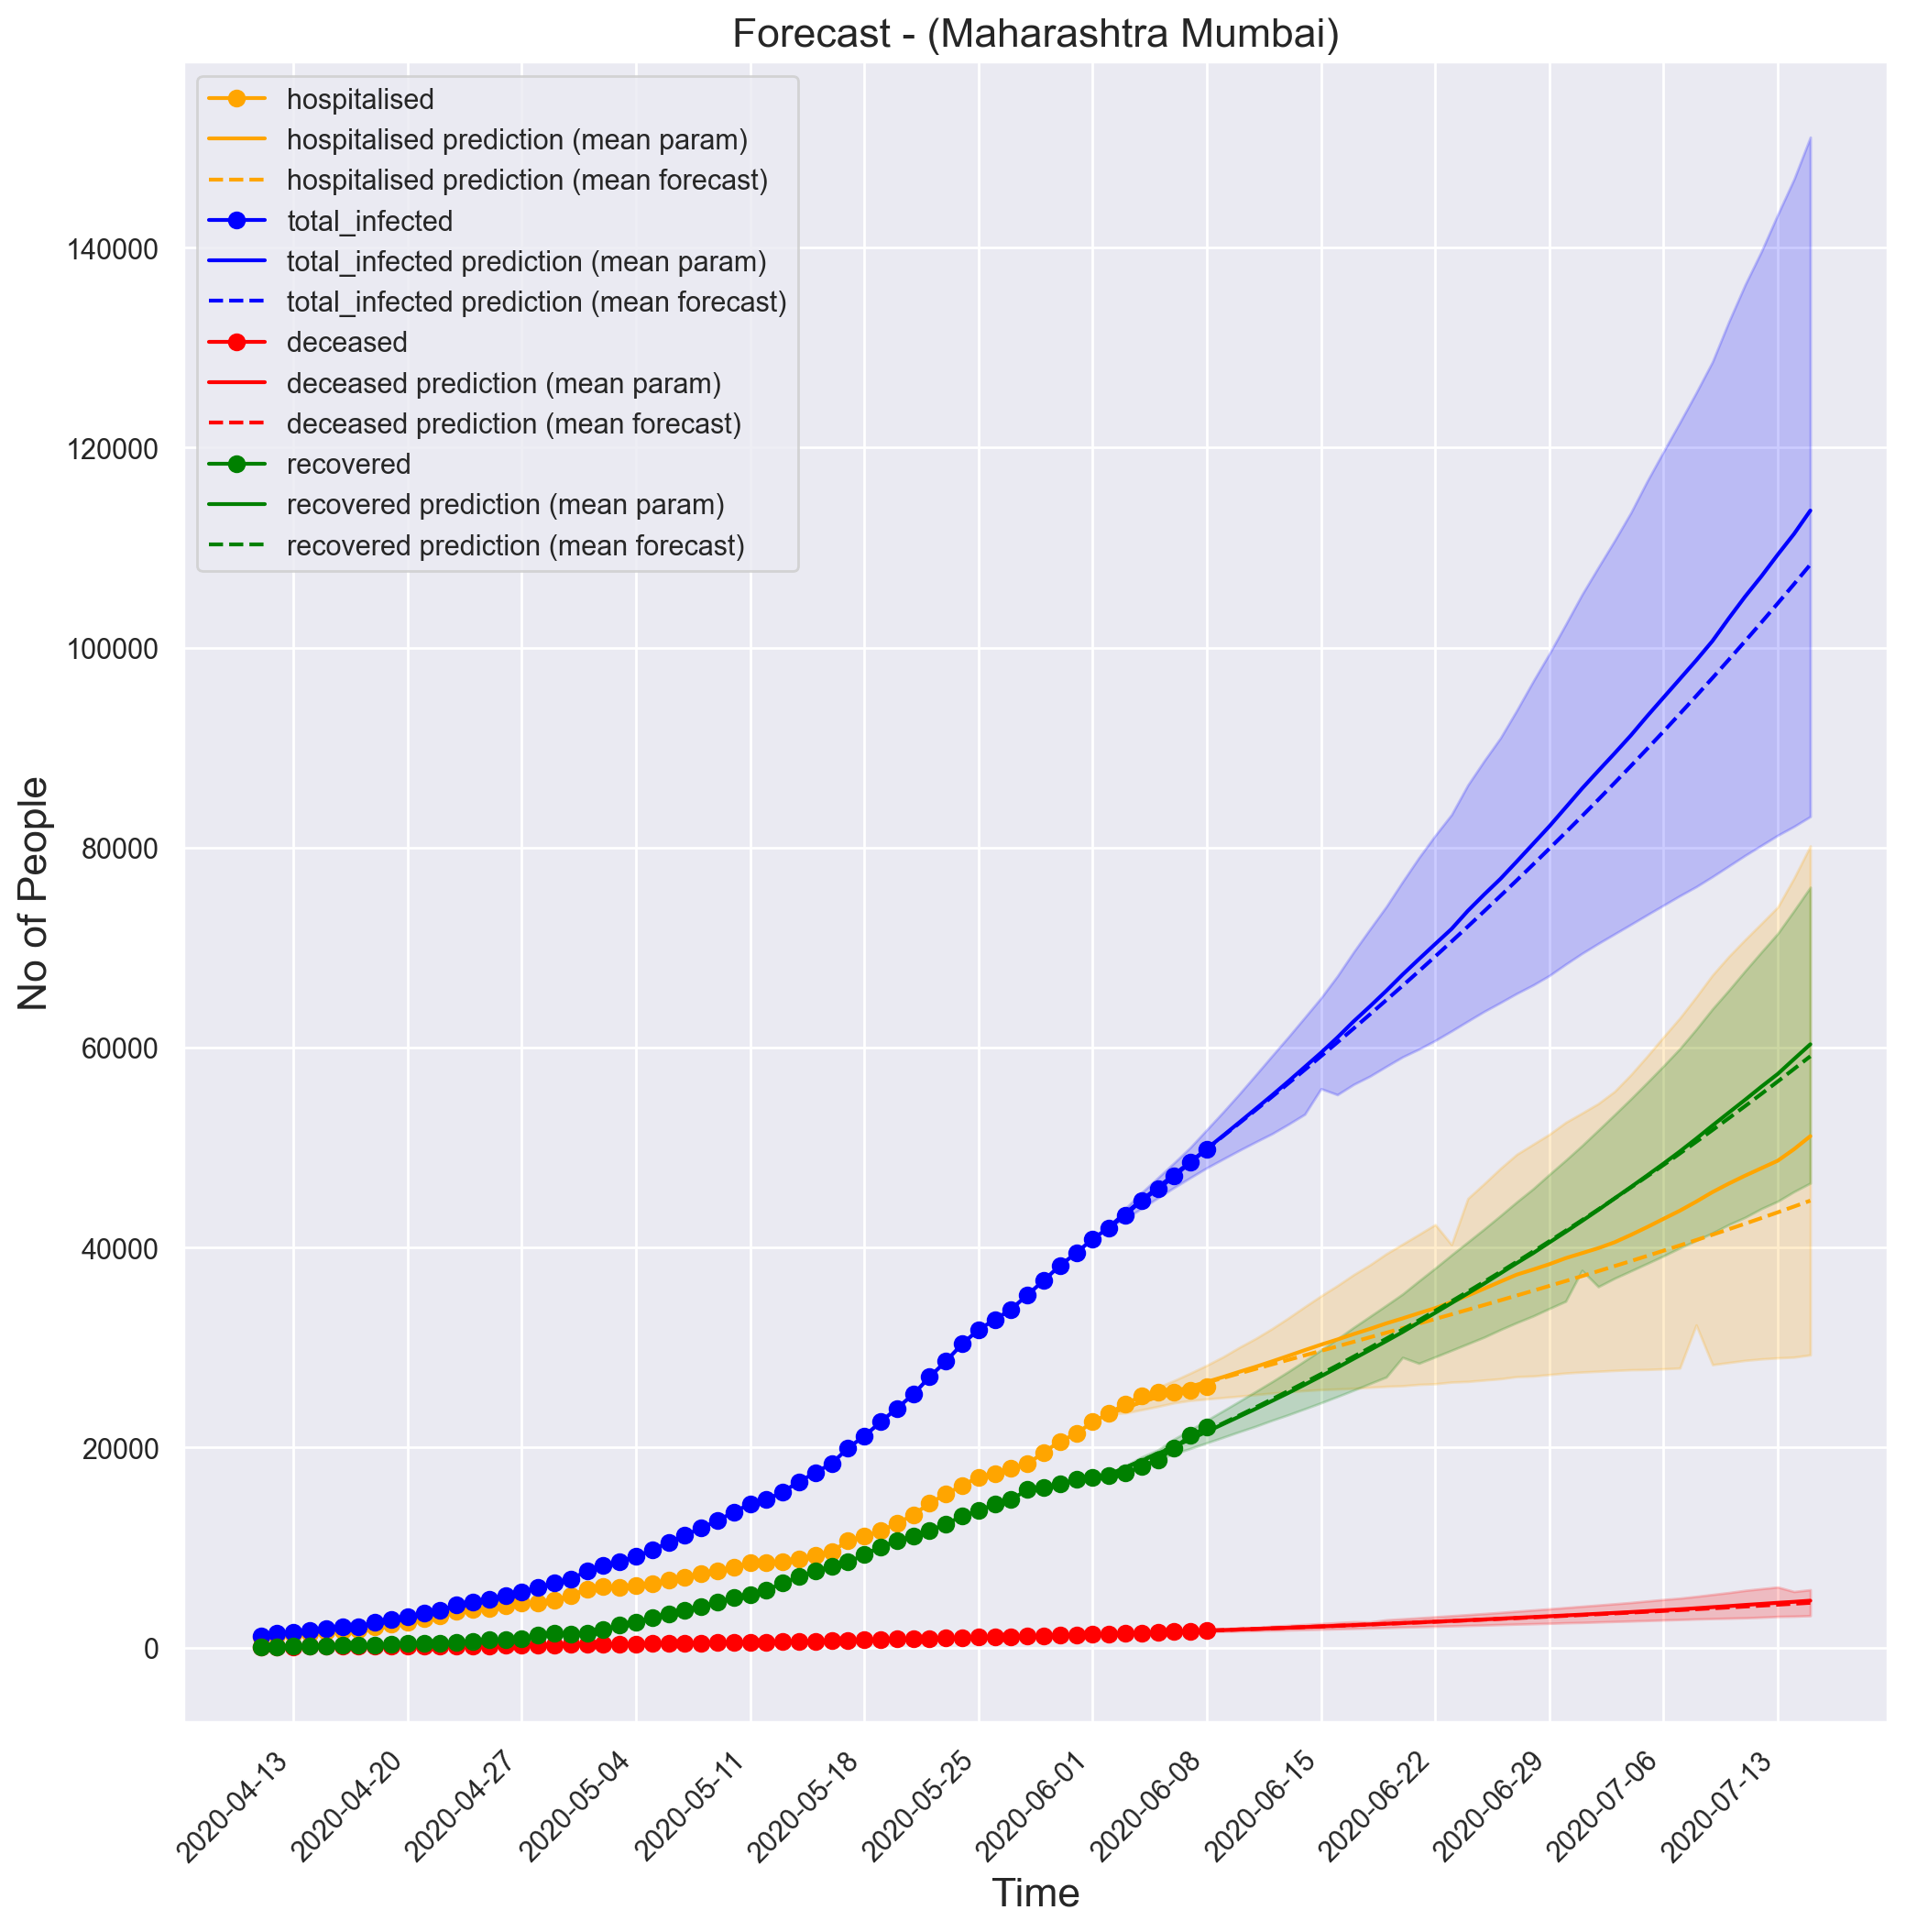

In [110]:
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']

df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
df_predictions = get_preds_m2()
sns.set()
#sns.set_style("darkgrid")
colors = ['orange', 'blue', 'red', 'green']
ci_cols = {}
fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.figsize']=[30, 50]
plt.rcParams.update({'font.size':20})
for idx, compartment in enumerate(['hospitalised', 'total_infected', 'deceased', 'recovered']):
    ax.plot(df_true['date'], df_true[compartment],
            '-o', color= colors[idx], label= compartment)
    ci_cols[idx] = pd.DataFrame([gen_CI(i, compartment) for i in range(len(all_forecasts))])
    ci_cols[idx].columns = ['date', 'lower', 'upper']
    full_data = pd.concat([ci_cols[idx][['date','upper']].rename(columns={'upper':compartment}),
                           ci_cols[idx][['date', 'lower']].rename(columns={'lower':compartment}),
                           df_predictions[['date',compartment]]], axis = 0)
    
    sns.lineplot(data = full_data, y =  compartment,  x ='date' , 
                 ls='-', color = colors[idx], label= compartment+" prediction (mean param)" )
    ax.plot(df_predictions_mf['date'],  df_predictions_mf[compartment], '--',
                  color = colors[idx], label= compartment+" prediction (mean forecast)" )
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()   
fig.tight_layout()